In [29]:
import os
import json
import geopandas as gpd
from PIL import Image, ImageOps, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import ImageGrid
from datetime import datetime, timedelta
import numpy.ma as ma
from datetime import datetime
import pandas as pd

,field_1,field_2,field_3,field_4,field_5,field_6,field_7,field_8,field_9,field_10,...,field_1288,field_1289,field_1290,field_1291,field_1292,field_1293,field_1294,field_1295,field_1296,field_1297
0,-0.117,-0.133,-0.039,0.031,-0.016,-0.047,-0.055,-0.039,-0.031,-0.008,...,0.445,0.438,0.383,0.438,0.445,0.445,0.445,0.445,0.008,
1,-0.125,0.023,-0.125,-0.188,0.031,0.008,-0.023,-0.008,-0.031,-0.125,...,0.398,0.445,0.484,0.453,0.477,0.477,0.477,0.477,0.016,
2,0.008,-0.039,0.047,0.023,-0.078,0.023,-0.094,-0.047,-0.062,-0.047,...,0.352,0.336,0.391,0.539,0.453,0.453,0.453,0.453,0.008,
3,-0.031,0.055,-0.133,-0.125,0.117,-0.016,-0.047,0.070,0.023,0.039,...,0.336,0.359,0.359,0.414,0.477,0.477,0.477,0.477,-0.023,
4,-0.023,-0.047,-0.078,-0.047,-0.016,-0.039,-0.016,-0.062,-0.039,-0.070,...,0.398,0.445,0.414,0.406,0.281,0.281,0.281,0.281,0.008,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,0.273,0.281,0.141,0.086,0.055,0.164,0.133,0.219,0.039,-0.086,...,0.008,0.102,0.164,0.039,0.039,0.039,0.039,0.039,0.125,
238,0.336,0.242,0.289,0.250,0.305,0.250,0.258,0.156,0.203,0.320,...,0.234,0.039,0.125,0.016,-0.039,-0.039,-0.039,-0.039,0.164,
239,0.281,0.227,0.164,0.117,0.195,0.219,0.367,0.258,0.047,-0.055,...,0.156,0.055,0.273,0.086,0.234,0.234,0.234,0.234,0.062,
240,0.266,0.289,0.195,0.227,0.250,0.203,0.227,0.266,0.164,0.008,...,0.266,0.047,0.078,-0.102,0.055,0.055,0.055,0.055,0.156,


In [2]:
data_dir='/home/ajai-krishna/work/Phenocam_d3/Phenocamdata'
plot_dir='/home/ajai-krishna/work/Phenocam_d3/Plots'
file_path=[os.path.join(data_dir,i) for i in os.listdir(data_dir)]
file_path

['/home/ajai-krishna/work/Phenocam_d3/Phenocamdata/APU_pos_01_2025_08_10_11_20_45_NDVI(5).jpg',
 '/home/ajai-krishna/work/Phenocam_d3/Phenocamdata/APU_pos_01_2025_10_02_11_30_14.jpg',
 '/home/ajai-krishna/work/Phenocam_d3/Phenocamdata/APU_pos_01_2025_08_25_11_20_48_NDVI(1).jpg',
 '/home/ajai-krishna/work/Phenocam_d3/Phenocamdata/APU_pos_01_2025_10_05_11_31_05_NDVI.jpg',
 '/home/ajai-krishna/work/Phenocam_d3/Phenocamdata/APU_pos_01_2025_09_09_11_20_14.jpg',
 '/home/ajai-krishna/work/Phenocam_d3/Phenocamdata/APU_pos_01_2025_11_13_11_21_03_NDVI.jpg',
 '/home/ajai-krishna/work/Phenocam_d3/Phenocamdata/APU_pos_01_2025_10_30_11_00_15.jpg',
 '/home/ajai-krishna/work/Phenocam_d3/Phenocamdata/APU_pos_01_2025_11_04_11_10_14.jpg',
 '/home/ajai-krishna/work/Phenocam_d3/Phenocamdata/APU_pos_01_2025_10_29_11_21_02_NDVI.jpg',
 '/home/ajai-krishna/work/Phenocam_d3/Phenocamdata/APU_pos_01_2025_10_08_11_30_14.jpg',
 '/home/ajai-krishna/work/Phenocam_d3/Phenocamdata/APU_pos_01_2025_10_28_11_00_14.jpg',
 

In [3]:
df1 = pd.DataFrame(file_path, columns=['file_path'])
df1['image_type'] = df1['file_path'].apply(lambda x: 'rgb' if x.lower().endswith('_color.jpg') 
                                           else ('ir' if x.lower().endswith('_ir.jpg') else ('NDVI' if x.lower().endswith('_ndvi.jpg') else 'other')))
df1['date_time'] = df1['file_path'].apply(lambda x: os.path.basename(x).split('APU_pos_01_')[-1].rsplit('_', 1)[0])
#df1['datetime_obj'] = pd.to_datetime(df1['date_time'], format='%Y_%m_%d_%H%M%S')
df1['date'] = df1['date_time'].apply(lambda x: "_".join(x.split('_')[0:3]))
df1['time'] = df1['date_time'].apply(lambda x: "".join(x.split('_')[3:][:2]))
#df1['time'] = pd.to_datetime(df1['time'], format='%H%M').dt.time
df1

,file_path,image_type,date_time,date,time
0,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,other,2025_08_10_11_20_45,2025_08_10,1120
1,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,other,2025_10_02_11_30,2025_10_02,1130
2,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,other,2025_08_25_11_20_48,2025_08_25,1120
3,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,NDVI,2025_10_05_11_31_05,2025_10_05,1131
4,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,other,2025_09_09_11_20,2025_09_09,1120
...,...,...,...,...,...
1397,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,other,2025_09_11_11_30,2025_09_11,1130
1398,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,rgb,2025_08_25_11_30_50,2025_08_25,1130
1399,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,ir,2025_08_25_11_20_48,2025_08_25,1120
1400,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,NDVI,2025_09_08_11_21_13,2025_09_08,1121


In [37]:
df_ndvi=df1[df1['image_type']=='NDVI']
df_ndvi

,file_path,image_type,date_time,date,time,temp
3,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,NDVI,2025_10_05_11_31_05,2025_10_05,1131,NaN
5,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,NDVI,2025_11_13_11_21_03,2025_11_13,1121,NaN
8,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,NDVI,2025_10_29_11_21_02,2025_10_29,1121,NaN
19,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,NDVI,2025_11_16_11_21_02,2025_11_16,1121,NaN
30,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,NDVI,2025_09_27_11_31_04,2025_09_27,1131,NaN
...,...,...,...,...,...,...
1372,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,NDVI,2025_11_08_11_31_02,2025_11_08,1131,NaN
1379,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,NDVI,2025_09_10_11_31_11,2025_09_10,1131,NaN
1387,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,NDVI,2025_11_08_11_11_05,2025_11_08,1111,NaN
1396,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,NDVI,2025_10_04_11_31_07,2025_10_04,1131,NaN


In [5]:
ndvi_img=np.array(Image.open(df_ndvi['file_path'][3]))
rows=cols=10
h, w = ndvi_img.shape[:2]
tile_h= h // rows
tile_w = w//rows
tiles = []
mean_ndvi = np.zeros((rows, cols))

for i in range(rows):
    for j in range(cols):
        tile = ndvi_img[
            i*tile_h:(i+1)*tile_h,
            j*tile_w:(j+1)*tile_w
        ]
        tiles.append(tile)
        mean_ndvi[i,j]=np.nanmean(tile)

In [38]:
ndvi_img.shape

(1984, 2592, 3)

In [6]:
tiles[0].shape


(198, 259, 3)

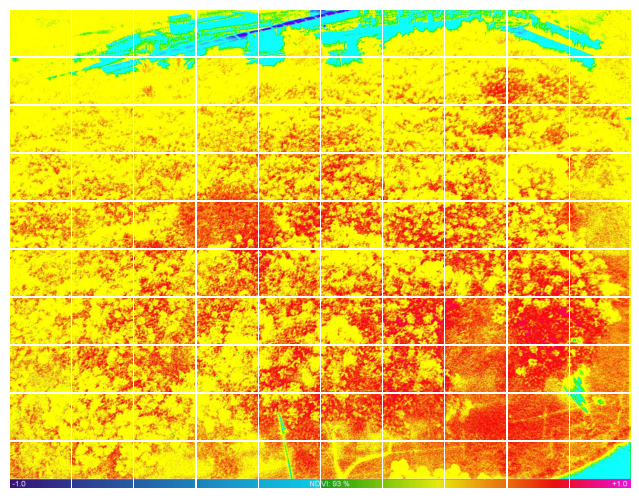

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(8,8))
grid = ImageGrid(fig, 111, nrows_ncols=(10, 10), axes_pad=0.02)

k = 0
for i in range(10):
    for j in range(10):
        tile = ndvi_img[
            i*tile_h:(i+1)*tile_h,
            j*tile_w:(j+1)*tile_w
        ]
        grid[k].imshow(tile)
        grid[k].axis('off')
        k += 1

plt.show()


In [8]:
dates = df1['date'].unique()
selected_fils = []
for date in dates:
    group = df1[df1['date'] == date]
    ir_times = group[group['image_type'] == 'ir']['time'].values
    rgb_times = group[group['image_type'] == 'rgb']['time'].values
    common_times = set(ir_times).intersection(set(rgb_times))
    time1 = common_times.pop() if common_times else None
    if time1:
        ir_file = group[(group['image_type'] == 'ir') & (group['time'] == time1)]['file_path'].values[0]
        rgb_file = group[(group['image_type'] == 'rgb') & (group['time'] == time1)]['file_path'].values[0]
        selected_fils.append({'date': date, 
                              'time': time1, 
                              'ir_file':ir_file, 
                              'rgb_file':rgb_file})


In [9]:
df=pd.DataFrame(selected_fils).sort_values(by=['date','time']).reset_index(drop=True)
df

,date,time,ir_file,rgb_file
0,2025_08_08,1120,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...
1,2025_08_09,1120,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...
2,2025_08_10,1120,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...
3,2025_08_11,1120,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...
4,2025_08_12,1120,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...
...,...,...,...,...
59,2025_11_12,1131,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...
60,2025_11_13,1131,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...
61,2025_11_14,1131,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...
62,2025_11_15,1131,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...


In [10]:

def select_time(group):
    ir_time = group[group['image_type'] == 'ir']['time'].values
    rgb_df = group[group['image_type'] == 'rgb']['time'].values
    for time1 in ir_time:
        if time1 in rgb_df:
            return time1    

df1['temp']= df1.groupby(['date']).apply(select_time)

/tmp/ipykernel_102784/187874625.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df1['temp']= df1.groupby(['date']).apply(select_time)


In [11]:
df1['temp'].unique()
df1

,file_path,image_type,date_time,date,time,temp
0,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,other,2025_08_10_11_20_45,2025_08_10,1120,NaN
1,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,other,2025_10_02_11_30,2025_10_02,1130,NaN
2,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,other,2025_08_25_11_20_48,2025_08_25,1120,NaN
3,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,NDVI,2025_10_05_11_31_05,2025_10_05,1131,NaN
4,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,other,2025_09_09_11_20,2025_09_09,1120,NaN
...,...,...,...,...,...,...
1397,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,other,2025_09_11_11_30,2025_09_11,1130,NaN
1398,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,rgb,2025_08_25_11_30_50,2025_08_25,1130,NaN
1399,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,ir,2025_08_25_11_20_48,2025_08_25,1120,NaN
1400,/home/ajai-krishna/work/Phenocam_d3/Phenocamda...,NDVI,2025_09_08_11_21_13,2025_09_08,1121,NaN


In [12]:
def ndvi_calculation(ir_path, rgb_path):
    # Load images
    ir_img = np.array(Image.open(ir_path)).astype(float)
    rgb = np.array(Image.open(rgb_path)).astype(float)

    # Extract IR band
    if ir_img.ndim == 3:
        ir = ir_img[:, :, 0]   # take one channel
    else:
        ir = ir_img

    # Extract Red band
    red = rgb[:, :, 0]

    # Avoid division by zero
    denominator = ir + red
    denominator[denominator == 0] = np.nan

    # NDVI calculation
    ndvi = (ir - red) / denominator

    # Return mean NDVI
    return np.nanmean(ndvi)



In [13]:
df['ndvi'] = df.apply(
    lambda row: ndvi_calculation(row['ir_file'], row['rgb_file']),
    axis=1
)


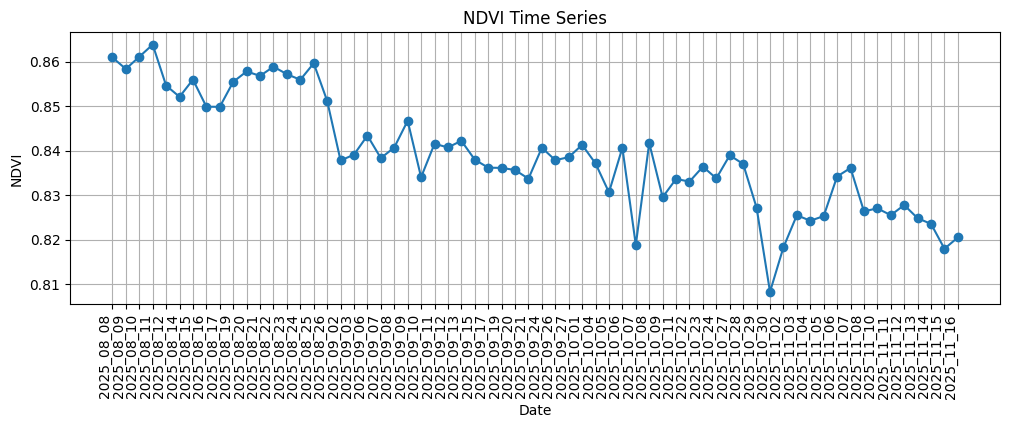

In [14]:


fig, ax = plt.subplots(figsize=(12,4))

ax.plot(df['date'], df['ndvi'], marker='o')

ax.set_ylabel('NDVI')
ax.set_xlabel('Date')
ax.set_title('NDVI Time Series')
# ax.set_ylim(-1, 1)
ax.grid(True)

# Auto-format dates
fig.autofmt_xdate()
plt.xticks(rotation=90, ha='right')
plot_path=os.path.join(plot_dir,'ndvi_plot')
plt.savefig(plot_path+'.png', bbox_inches='tight', dpi=300)
plt.show()
# os.path.join(plt.savefig('ndvi.json'))


In [15]:
plot_data= {
    "title": "NDVI Time Series",
    "xlabel": "Date",
    "ylabel": "NDVI",
    "x": df["date"].astype(str).tolist(), 
    "y": df["ndvi"].tolist(),
    "marker": "o",
    "grid": True
}

In [16]:
json_path = os.path.join(plot_dir, "ndvi_plot.json")

with open(json_path, "w") as f:
    json.dump(plot_data, f, indent=4)

print(f"Saved NDVI plot data to: {json_path}")


Saved NDVI plot data to: /home/ajai-krishna/work/Phenocam_d3/Plots/ndvi_plot.json


In [17]:

def select_data(group):
    ir_image_path = group[group['image_type'] == 'ir']['file_path'].values
    rgb_image_path = group[group['image_type'] == 'rgb']['file_path'].values
    ir_time=group[group['image_type'] == 'ir']['time'].values
    
df1.groupby('date').apply(select_data)

/tmp/ipykernel_102784/1589382918.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df1.groupby('date').apply(select_data)


""


In [18]:
test_image_ir='/home/ajai-krishna/work/Phenocam_d3/Phenocamdata/APU_pos_01_2025_07_28_13_44_47_ir(1).jpg'
# test_image_color='/home/ajai-krishna/work/Phenocam_d3/Phenocamdata/APU_pos_01_2025_07_28_13_42_14(1).jpg'
test_image_color='/home/ajai-krishna/work/Phenocam_d3/Phenocamdata/APU_pos_01_2025_07_28_13_44_47_color(1).jpg'
img_ir= Image.open(test_image_ir)   
img_color=Image.open(test_image_color)
img_ir.load()
img_color.load()
# img
#img_ir = np.mean(img_ir,axis=3

In [19]:
mean_ir = np.mean(np.array(img_ir).astype(float),axis=2)
mean_vis = np.mean(np.array(img_color).astype(float),axis=2)

plt.hist(mean_vis)

In [20]:
ndvi_vis = (mean_ir - mean_vis)/(mean_vis+mean_ir)

In [21]:
# Convert images to grayscale (returns new images)
# img_ir = img_ir.convert('L')
# img_color = img_color.convert('RGB')  # Keep color as RGB to extract red channel

# Convert to numpy arrays
img_ir_array = np.array(img_ir)
img_color_array = np.array(img_color)

# Convert to float for calculation
img_ir = img_ir_array[:, :, 0].astype(float)
img_r = img_color_array[:, :, 0].astype(float)

/tmp/ipykernel_102784/562968272.py:3: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where(denominator != 0, (img_ir - img_r) / denominator, 0)


Text(0.5, 1.0, 'NDVI')

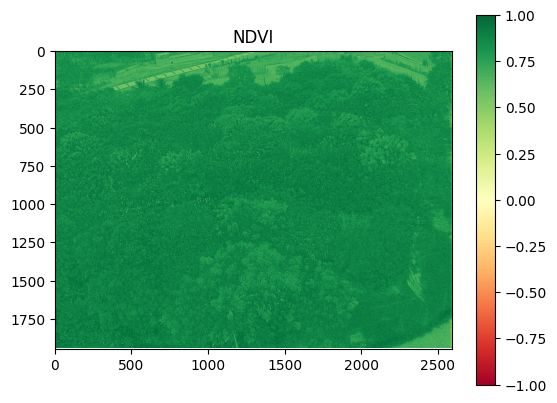

In [22]:


# Calculate NDVI with division by zero handling
denominator = img_ir + img_r
ndvi = np.where(denominator != 0, (img_ir - img_r) / denominator, 0)

# Display NDVI
plt.imshow(ndvi, cmap='RdYlGn',vmin=-1)  # Use appropriate colormap for NDVI
plt.colorbar()
plt.title('NDVI')

In [23]:
img_ir.shape,img_r.shape


((1944, 2592), (1944, 2592))

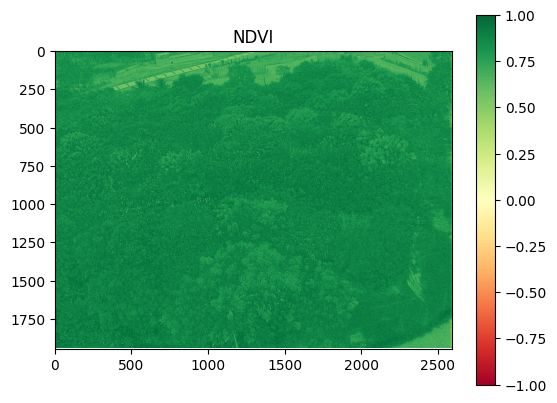

(1944, 2592)

In [24]:
neg_ndvi = ndvi*ndvi<0
plt.imshow(ndvi, cmap='RdYlGn')  # Use appropriate colormap for NDVI
plt.colorbar()
plt.title('NDVI')
# plt.savefig('/home/ajai-krishna/work/Phenocam_d3/static/images/test_ndvi.png',dpi=600)
plt.show()
# Image.fromarray(ndvi).save("/home/ajai-krishna/work/Phenocam_d3/static/images/test_ndvi.tif")
ndvi.shape

In [25]:
np.sum(ndvi== 1)

np.int64(65363)

In [26]:
mask = '/home/ajai-krishna/work/Phenocam_d3/Mask/mask.jpg'
mask_img = Image.open(mask)

# Convert mask to grayscale ('L' mode) if it isn't already
mask_img = mask_img.convert('L')

# Resize mask to match image dimensions if needed
if mask_img.size != img_ir.size:
    mask_img = mask_img.resize(img_ir.size)

# Apply mask to IR image
img_cropped_ir = Image.composite(
    img_ir,
    Image.new('L', img_ir.size, 0),
    mask_img
)

# Apply mask to RGB image
# Resize mask for color image if dimensions differ
mask_img_color = mask_img
if mask_img.size != img_color.size:
    mask_img_color = mask_img.resize(img_color.size)

img_cropped_color = Image.composite(
    img_color,
    Image.new('RGB', img_color.size, (0, 0, 0)),
    mask_img_color
)

img_cropped_color.show()

TypeError: 'int' object is not iterable

In [ ]:
img_array_ir=np.array(img_cropped_ir)
img_array_color=np.array(img_cropped_color)
img_array_color.shape

In [ ]:
plt.imshow(img_array_ir)
plt.imshow(img_array_color[:,:,0],cmap='Reds')


In [ ]:

masked_array_color = ma.masked_where(img_array_color == 0, img_array_color)
masked_array_ir=ma.masked_where(img_array_ir==0,img_array_ir)
plt.imshow(masked_array_color[:,:,0])

In [ ]:
ir = masked_array_ir.astype(float)
r = masked_array_color[:, :, 0].astype(float)
ndvi = (ir - r) / (ir + r)
ndvi = ma.masked_invalid(ndvi)
plt.imshow(ndvi)
plt.colorbar()

In [ ]:
print("IR mean:", ir.mean())
print("Red mean:", r.mean())
print("IR > Red pixels:", np.sum(ir > r), "out of", ir.size)

In [ ]:
total = ma.mean(ndvi.flatten())  # Sum of non-masked values
total

In [ ]:
masked_array_ir.shape